In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Time Series Methods for Valuing Securities





In [7]:
import itertools
import pandas as pd
import numpy as np
from random import gauss

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox

from scipy.stats import shapiro
from scipy.stats import probplot

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

In [8]:
# general settings
class CFG:
    data_folder = '../input/tsdata-1/'
    img_dim1 = 20
    img_dim2 = 10
        
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})    

In [9]:
!pip install arch

# Volatility of Stock

Due to high variation in stocks to make a Time Series ARCH based model, need to take the first order difference of the data. We can try a second order differene if the variation of the data remains high.

<Axes: xlabel='Date'>

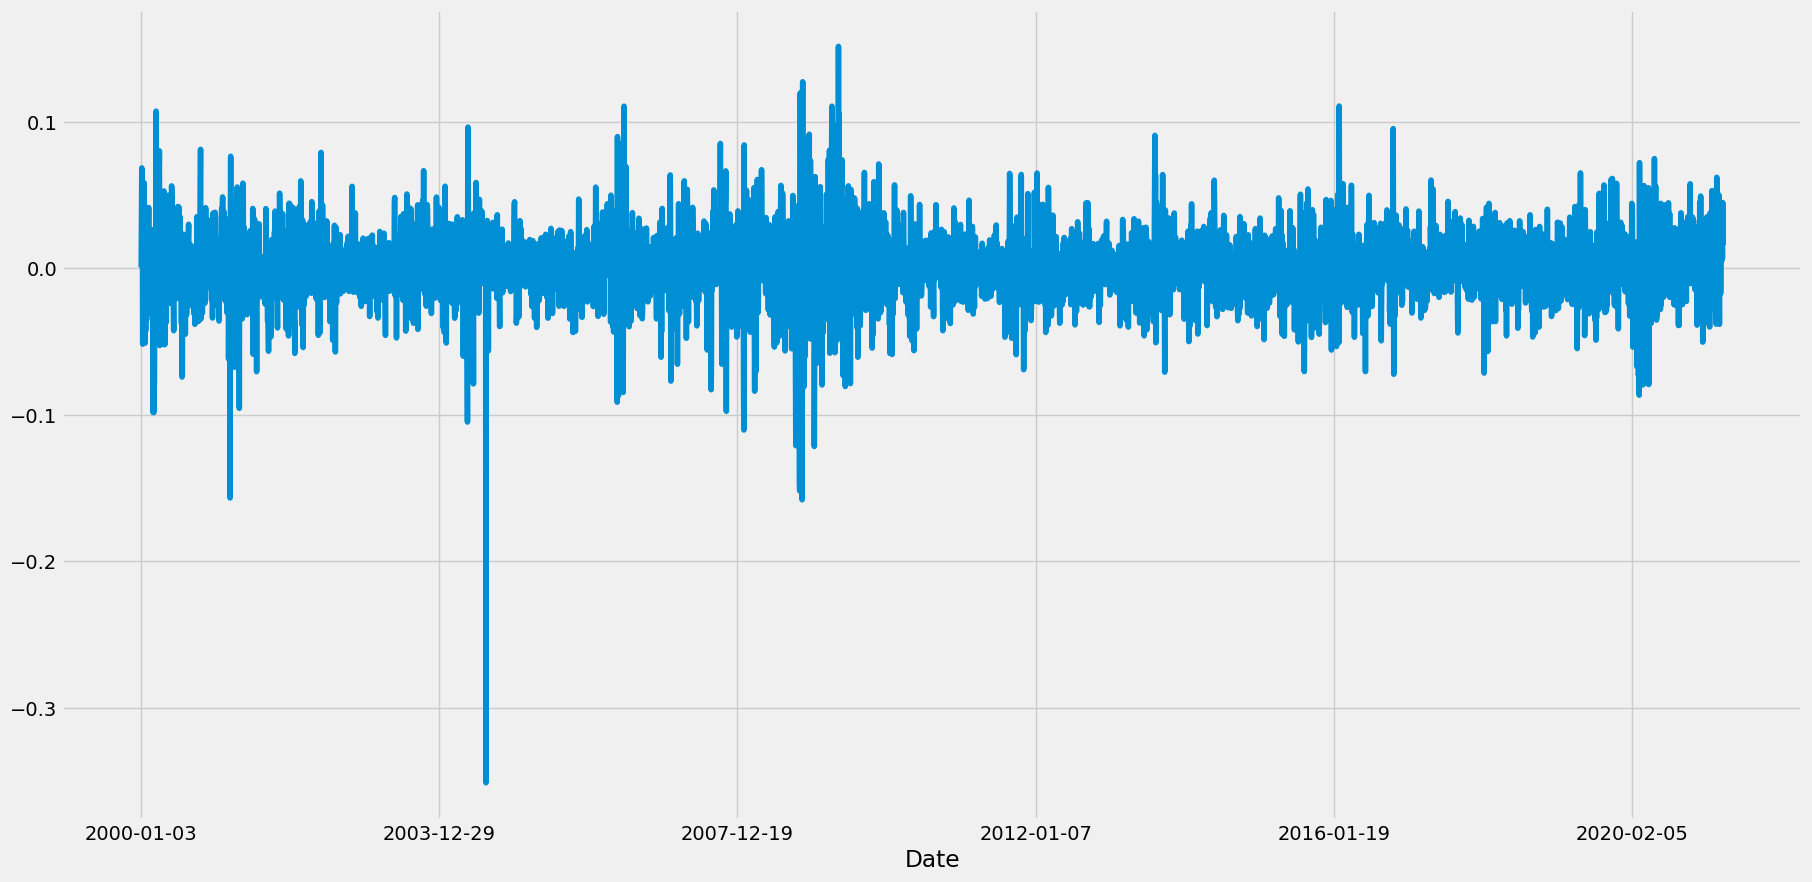

In [13]:
stock_name = 'TATASTEEL'
df = pd.read_csv('../input/nifty50-stock-market-data/archive/'+stock_name+'.csv')
df.set_index("Date", drop=False, inplace=True)

df.VWAP.pct_change().plot()

# Autocorrelation of returns

Remove variance of returns to get better predictions from models.

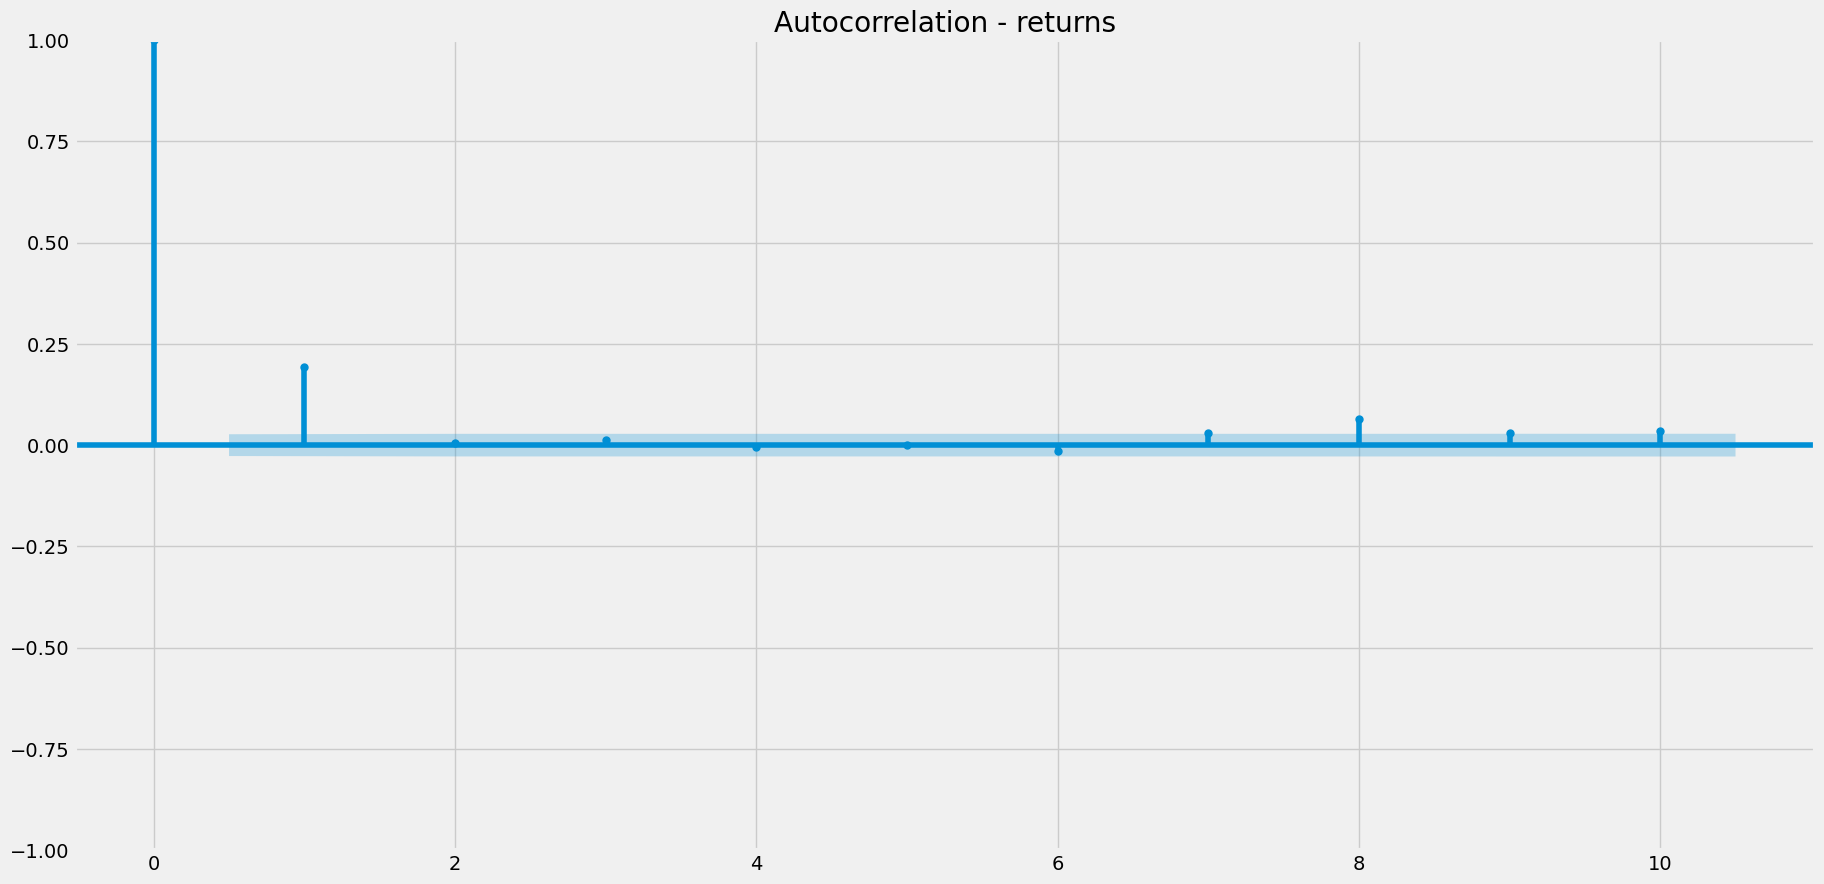

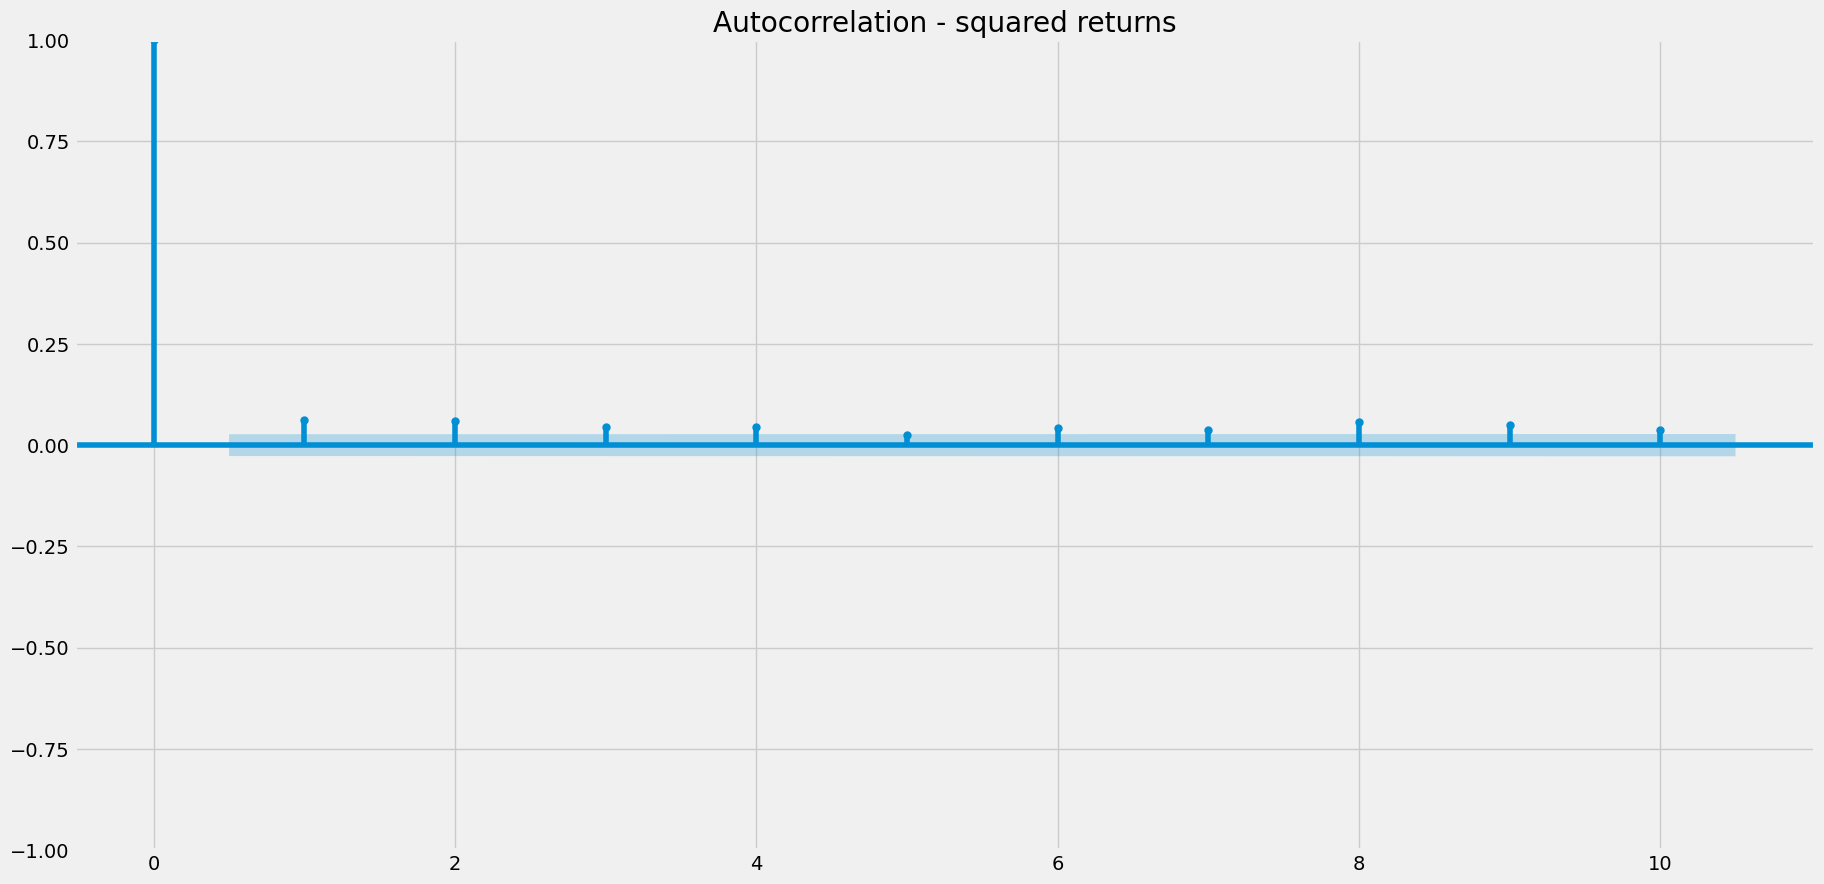

In [16]:
df1 = np.log1p(df.VWAP).diff().dropna()
plot_acf(df1, lags = 10, title = "Autocorrelation - returns"); print()
plot_acf(df1**2, lags = 10, title = "Autocorrelation - squared returns"); print()

# Partial autocorrelation of returns.

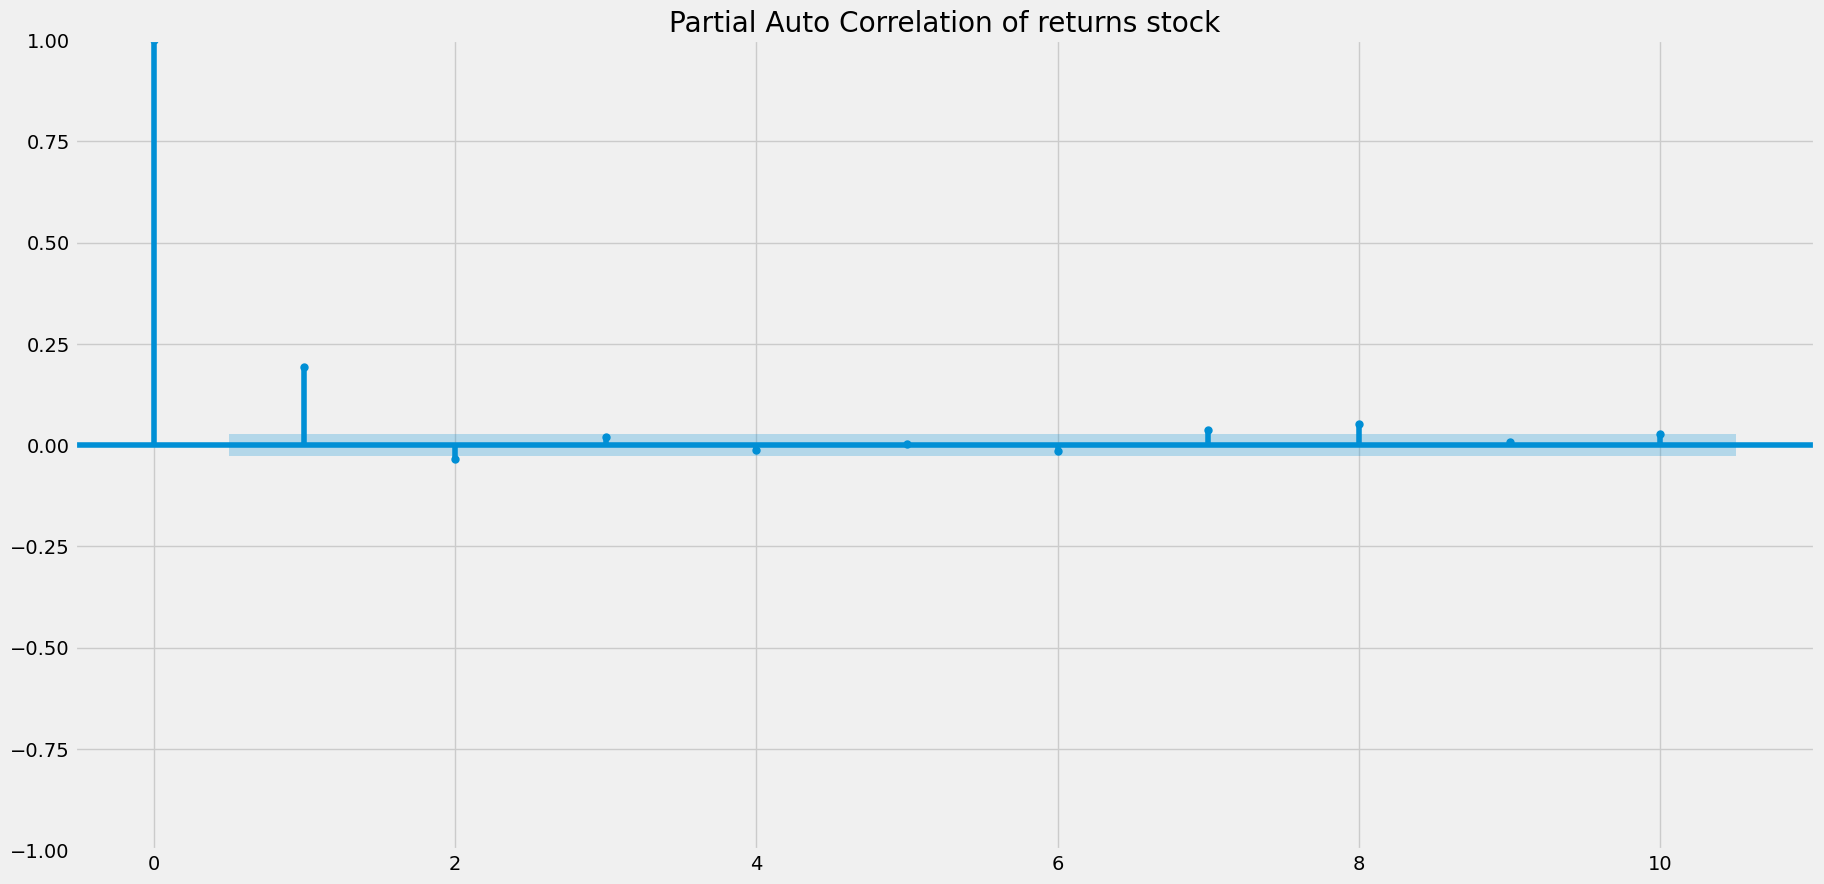

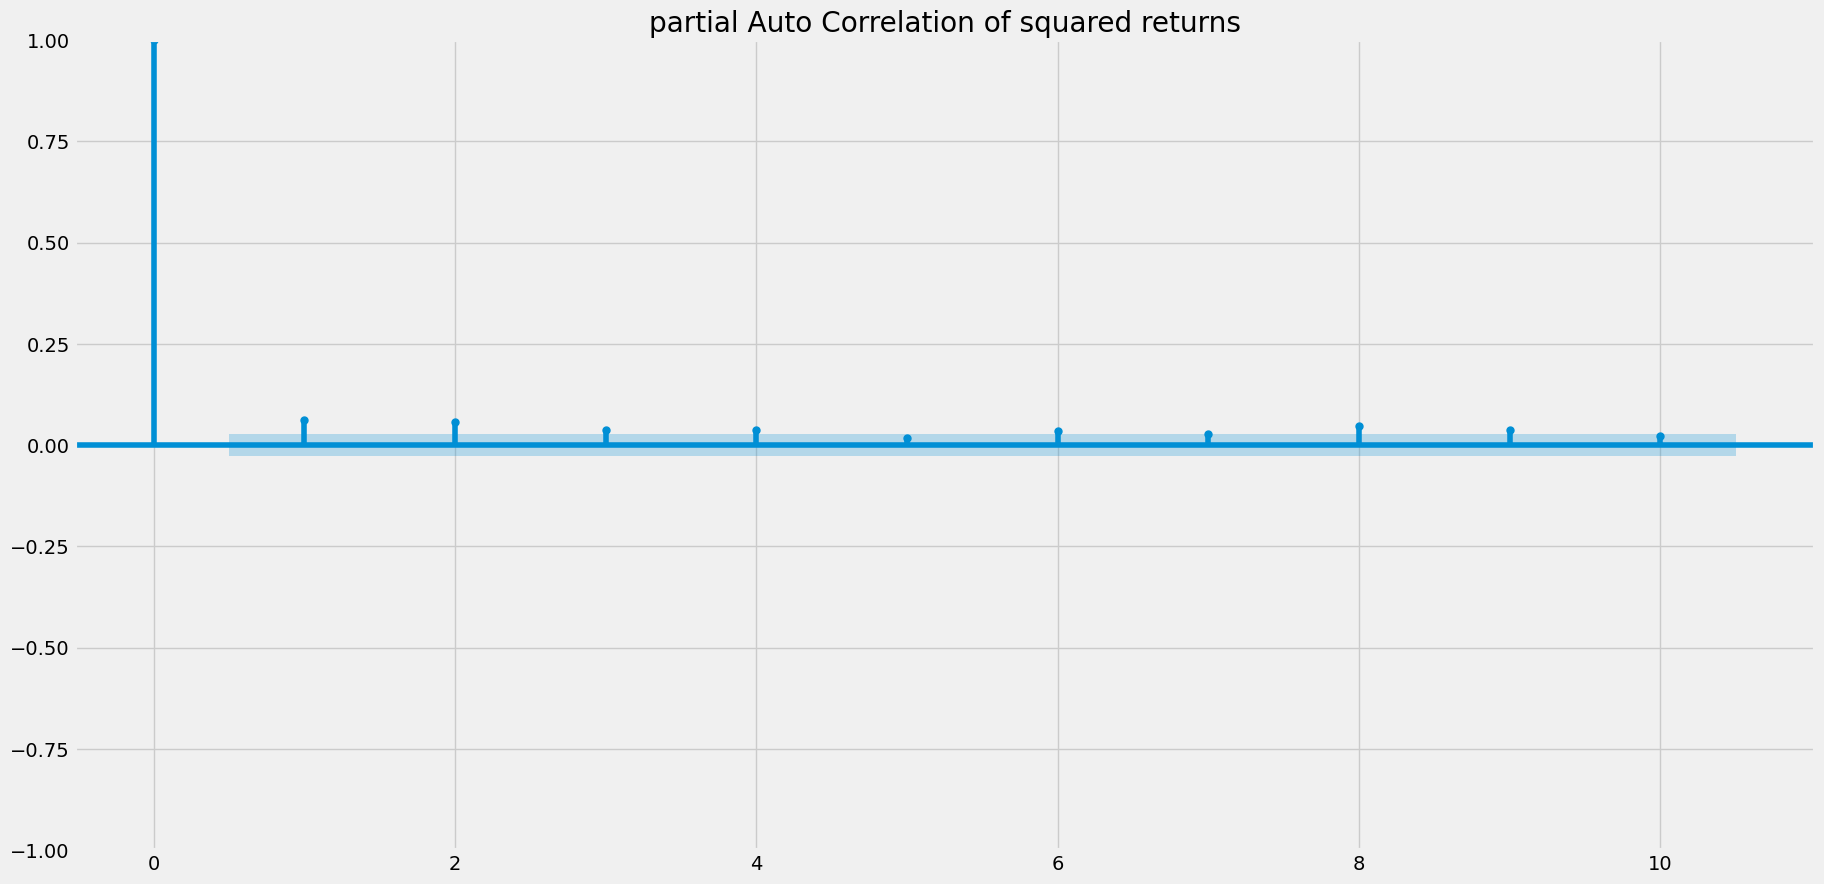

In [17]:
plot_pacf(df1,lags = 10, title = "Partial Auto Correlation of returns stock");print()
plot_pacf(df1**2, lags = 10, title = "partial Auto Correlation of squared returns"); print()

# Mean and Variance based Models

- ARCH based models

In [18]:
from arch import arch_model

am = arch_model(100 * df1, p = 1, q = 0)
res = am.fit(update_freq = 5)
print(res.summary())

Iteration:      5,   Func. Count:     32,   Neg. LLF: 12129.135686316393
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12129.106672226704
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                   VWAP   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -12129.1
Distribution:                  Normal   AIC:                           24264.2
Method:            Maximum Likelihood   BIC:                           24283.9
                                        No. Observations:                 5305
Date:                Tue, Jul 15 2025   Df Residuals:                     5304
Time:                        13:44:09   Df Model:                            1
        

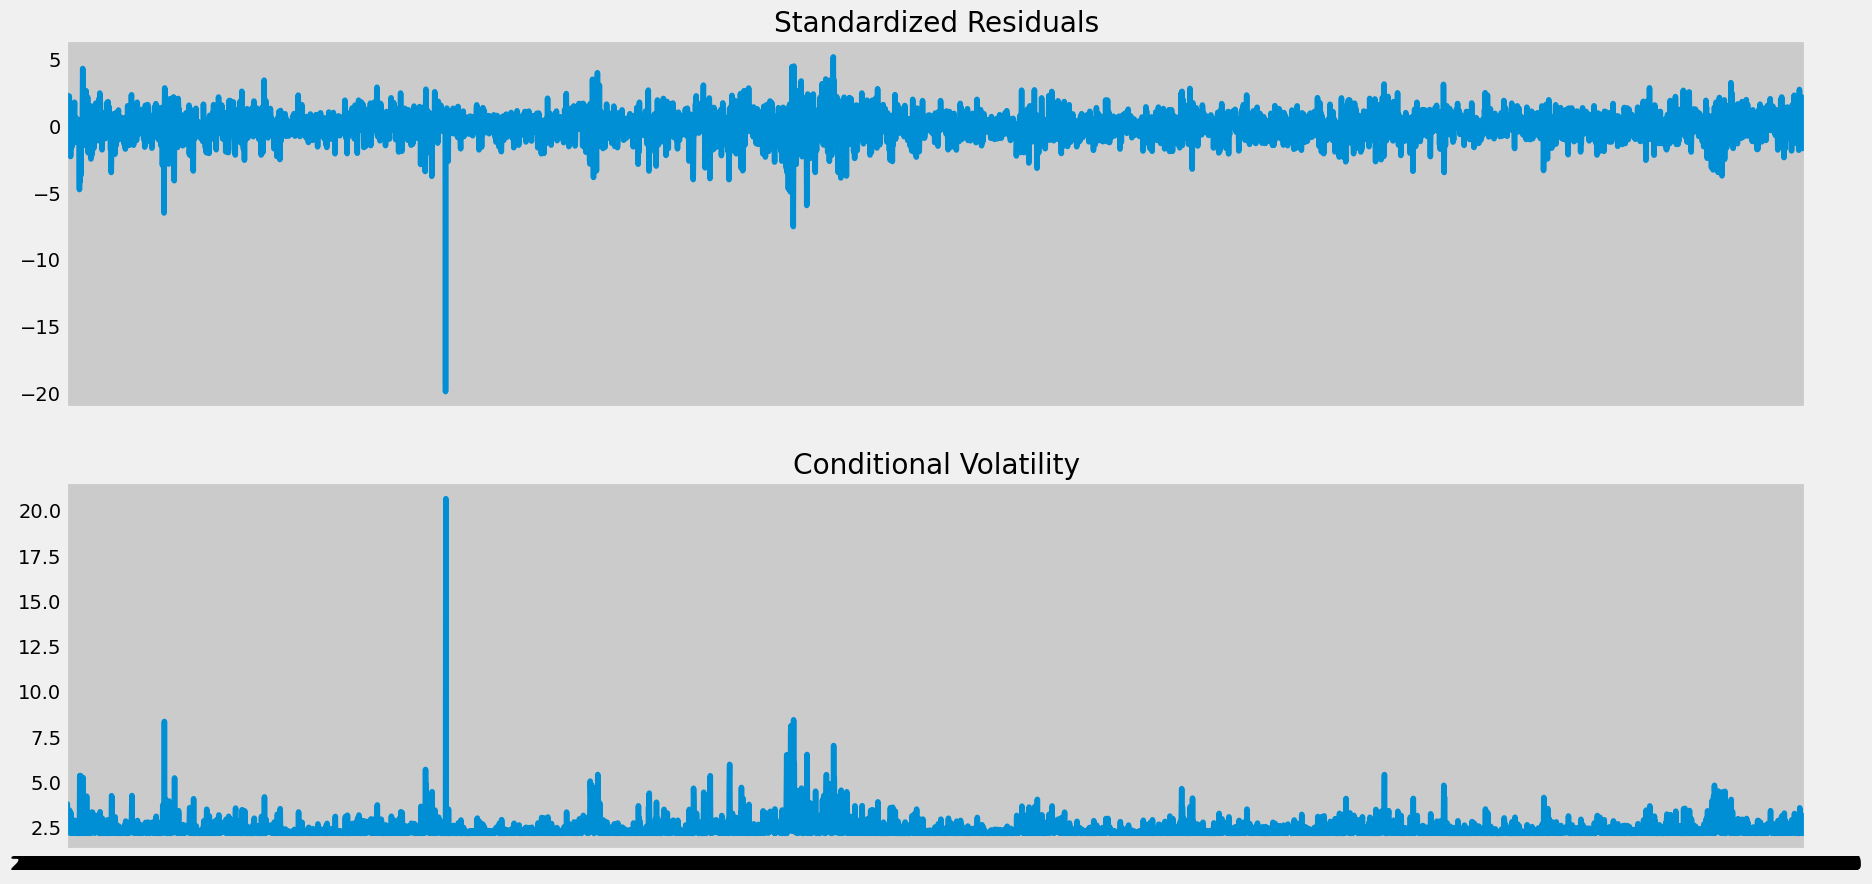

In [19]:
res.plot();print()

# GARCH Model

In [28]:
gm = arch_model(100 * df1, p = 1, q = 1)
res = gm.fit(update_freq = 5)
print(res.summary())

Iteration:      5,   Func. Count:     34,   Neg. LLF: 11838.138845776602
Iteration:     10,   Func. Count:     65,   Neg. LLF: 11835.563980028312
Optimization terminated successfully    (Exit mode 0)
            Current function value: 11835.561776522893
            Iterations: 13
            Function evaluations: 80
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   VWAP   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -11835.6
Distribution:                  Normal   AIC:                           23679.1
Method:            Maximum Likelihood   BIC:                           23705.4
                                        No. Observations:                 5305
Date:                Tue, Jul 15 2025   Df Residuals:                     5304
Time:       

In [41]:
# Engle ARCH
etest = het_arch(df1, maxlag=5)
print('pval Lagrange: ' + str(np.round(etest[1],4)))
print('pval F-test: ' + str(np.round(etest[1],4)))

pval Lagrange: 0.0
pval F-test: 0.0


In [42]:
etest = het_arch(st_residuals, maxlag=5)
print('pval Lagrange: ' + str(np.round(etest[1],4)))
print('pval F-test: ' + str(np.round(etest[1],4)))

pval Lagrange: 0.9966
pval F-test: 0.9966


# ARMA GARCH

In [44]:
from arch.univariate import ARX

ar = ARX(100 * df1, lags=[1, 3])
print(ar.fit().summary())

                     AR - Constant Variance Model Results                     
Dep. Variable:                   VWAP   R-squared:                       0.038
Mean Model:                        AR   Adj. R-squared:                  0.037
Vol Model:          Constant Variance   Log-Likelihood:               -12185.4
Distribution:                  Normal   AIC:                           24378.9
Method:            Maximum Likelihood   BIC:                           24405.2
                                        No. Observations:                 5302
Date:                Tue, Jul 15 2025   Df Residuals:                     5299
Time:                        14:39:16   Df Model:                            3
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          0.0270  3.328e-02      0.810      0.418 

In [45]:
from arch.univariate import ARCH, GARCH

ar.volatility = GARCH(p=1, q = 1)
res = ar.fit(update_freq=0, disp="off")
print(res.summary())

                           AR - GARCH Model Results                           
Dep. Variable:                   VWAP   R-squared:                       0.037
Mean Model:                        AR   Adj. R-squared:                  0.037
Vol Model:                      GARCH   Log-Likelihood:               -11726.4
Distribution:                  Normal   AIC:                           23464.8
Method:            Maximum Likelihood   BIC:                           23504.2
                                        No. Observations:                 5302
Date:                Tue, Jul 15 2025   Df Residuals:                     5299
Time:                        14:39:35   Df Model:                            3
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const           0.0116  3.169e-02      0.366      0.

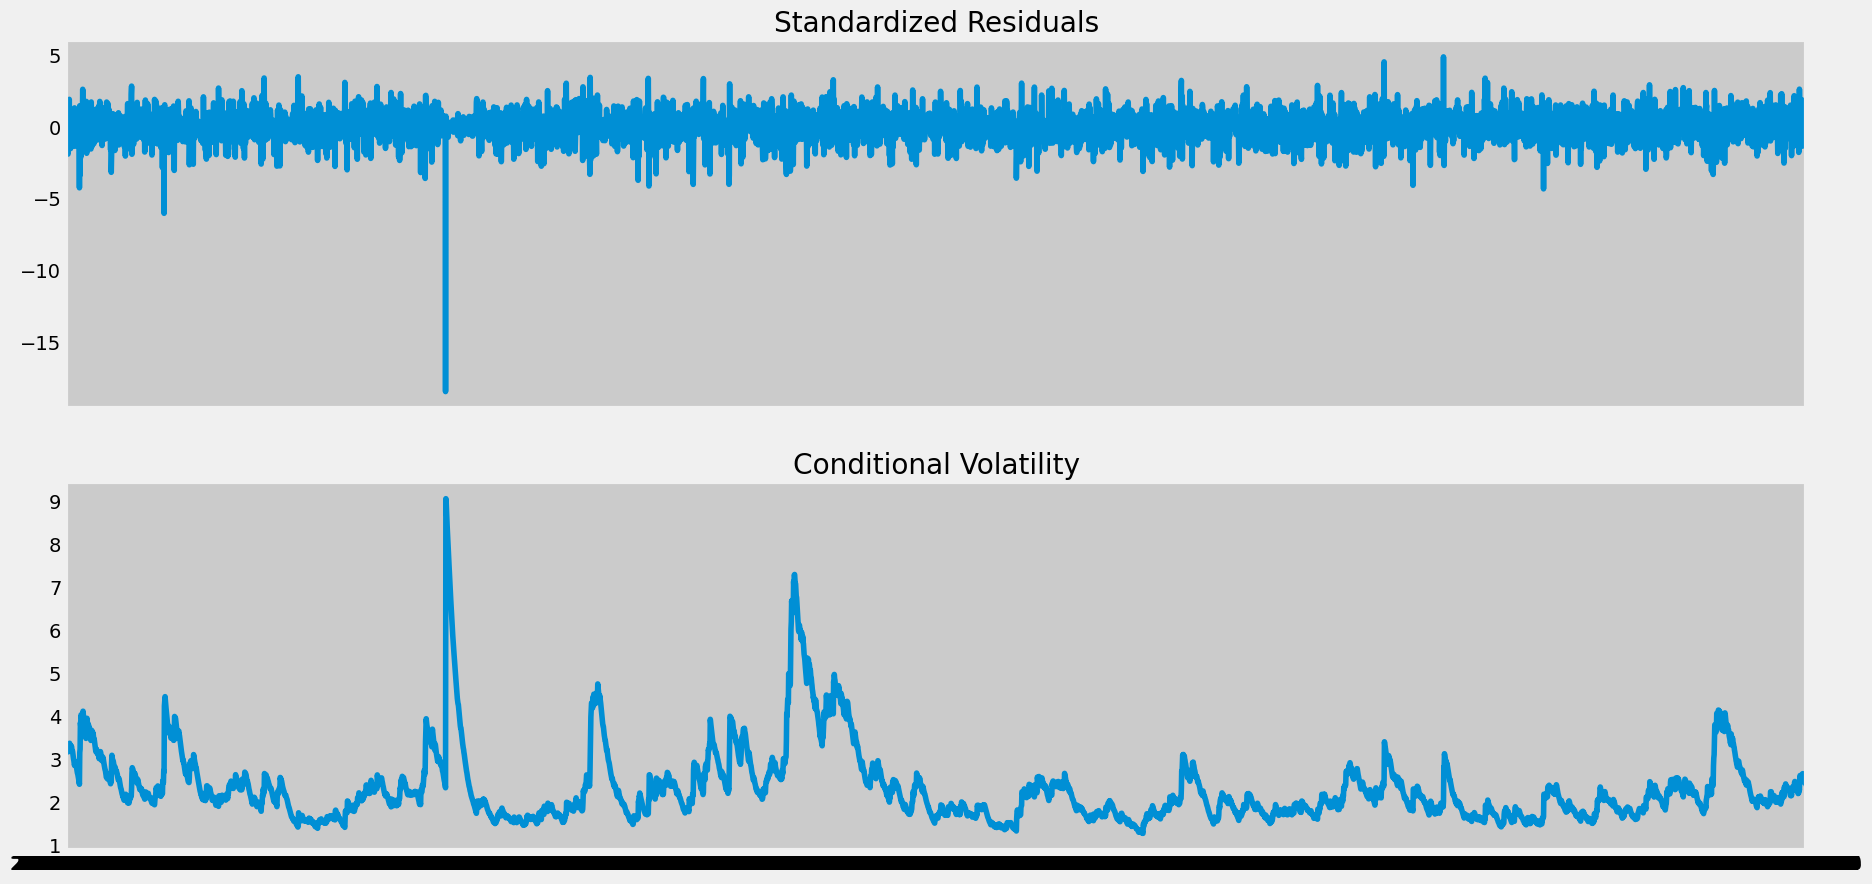

In [46]:
fig = res.plot()

# Forecasts

In [48]:
dfl = np.log1p(df.VWAP).diff().dropna()
print(dfl.index.min(), dfl.index.max())

2000-01-04 2021-04-30


In [49]:
# split into training and validation
xtr, xval = dfl.loc[:'2021-01-01'], dfl.loc['2021-01-01':]

In [50]:
# fit the model 

ar = ARX(100 * xtr, lags=[1])
ar.volatility = GARCH(p=1, q = 1)
res = ar.fit(update_freq=0, disp="off")
print(res.summary())


                           AR - GARCH Model Results                           
Dep. Variable:                   VWAP   R-squared:                       0.037
Mean Model:                        AR   Adj. R-squared:                  0.037
Vol Model:                      GARCH   Log-Likelihood:               -11547.9
Distribution:                  Normal   AIC:                           23105.7
Method:            Maximum Likelihood   BIC:                           23138.5
                                        No. Observations:                 5225
Date:                Tue, Jul 15 2025   Df Residuals:                     5223
Time:                        14:41:02   Df Model:                            2
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const      7.6356e-03  3.177e-02      0.240      0.810 

In [51]:
# build the forecast
xfor = res.forecast(horizon= xval.shape[0])

mean_forecast = xfor.mean.tail(1).values.reshape(len(xval),1)

forecast = pd.DataFrame()
forecast['Date'] = xval.index
forecast['VWAP'] = xval.values
forecast['fc_mean'] = xfor.mean.tail(1).values.reshape(len(xval),1)
forecast['fc_std'] = np.sqrt(xfor.variance.tail(1).values.reshape(len(xval),1))

In [52]:
forecast

,Date,VWAP,fc_mean,fc_std
0,2021-01-01,-0.000635,-0.005309,1.956875
1,2021-01-04,0.044198,0.006553,2.001682
2,2021-01-05,0.013379,0.008972,2.008021
3,2021-01-06,0.003357,0.009465,2.012758
4,2021-01-07,0.048117,0.009566,2.017403
...,...,...,...,...
75,2021-04-26,0.013062,0.009592,2.293163
76,2021-04-27,0.023504,0.009592,2.296414
77,2021-04-28,0.006857,0.009592,2.299649
78,2021-04-29,0.043910,0.009592,2.302870


In [53]:
import arch.data.sp500

data = arch.data.sp500.load()
market = data["Adj Close"]
returns = 100 * market.pct_change().dropna()

In [54]:
am = arch_model(returns, vol="Garch", p=1, o=0, q=1, dist="skewt")
res = am.fit(disp="off", last_obs="2017-12-31")

In [55]:
forecasts = res.forecast(start="2018-1-1", reindex=False)
cond_mean = forecasts.mean["2018":]
cond_var = forecasts.variance["2018":]
q = am.distribution.ppf([0.01, 0.05], res.params[-2:])
print(q)

[-2.64484752 -1.6496602 ]


# Risk Metric, Value at Risk of Security

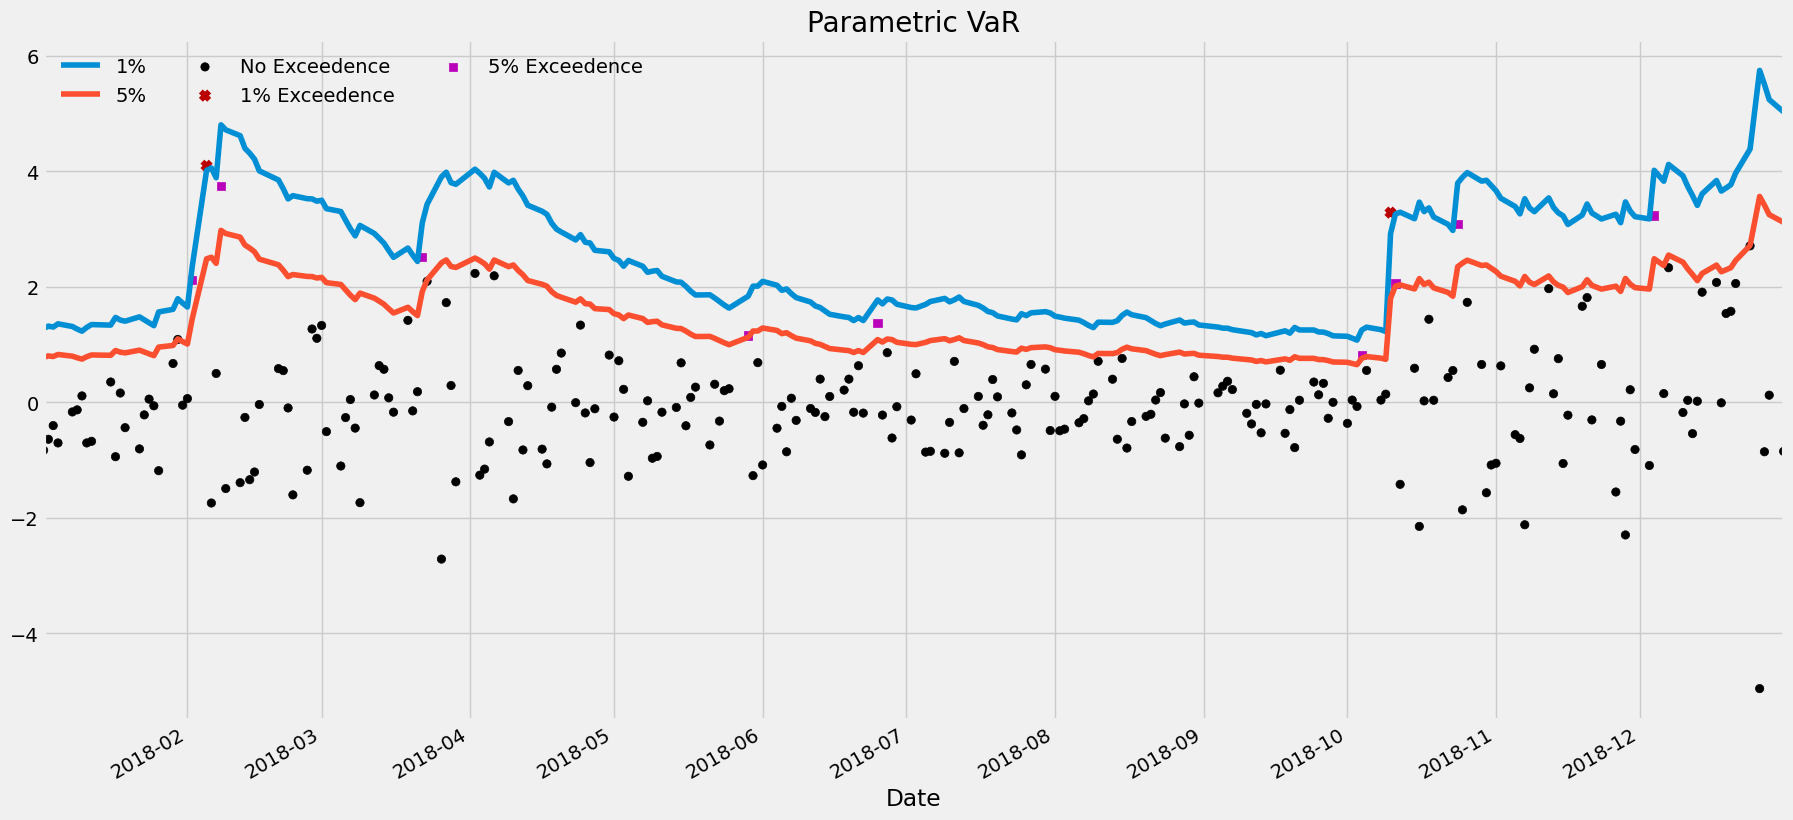

In [56]:
value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q[None, :]
value_at_risk = pd.DataFrame(value_at_risk, columns=["1%", "5%"], index=cond_var.index)
ax = value_at_risk.plot(legend=False)
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])
rets_2018 = returns["2018":].copy()
rets_2018.name = "S&P 500 Return"
c = []
for idx in value_at_risk.index:
    if rets_2018[idx] > -value_at_risk.loc[idx, "5%"]:
        c.append("#000000")
    elif rets_2018[idx] < -value_at_risk.loc[idx, "1%"]:
        c.append("#BB0000")
    else:
        c.append("#BB00BB")
c = np.array(c, dtype="object")
labels = {"#BB0000": "1% Exceedence", "#BB00BB": "5% Exceedence", "#000000": "No Exceedence",}
markers = {"#BB0000": "x", "#BB00BB": "s", "#000000": "o"}
for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets_2018.index[sel],
        -rets_2018.loc[sel],
        marker=markers[color],
        c=c[sel],
        label=labels[color],
    )
ax.set_title("Parametric VaR")
leg = ax.legend(frameon=False, ncol=3)